# CatBoost on MalbehavD-V1

Exploring the claims of CatBoost to use categorical data.

*Note that the hyperparameter `random_state` was set to `1` instead of `None` for test repeatability.*

# 0. Import Libraries

In [1]:
import time
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder #For LabelEncoding
from sklearn.model_selection import train_test_split #For Splitting Datasets
from sklearn.model_selection import RandomizedSearchCV #For automated hyperparameter tuning
import sklearn.model_selection as model_selection #For model selection (used in K-Folds)
from sklearn.metrics import classification_report #For Classification Report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #For Confusion Matrix
import matplotlib.pyplot as plt #For figure plotting

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTEN

import lightgbm as lgbm
import catboost as catb
import xgboost as xgb

# 1. Import Dataset

In [2]:
malbd = pd.read_csv("malbd.csv")
malbd

,sha256,labels,0,1,2,3,4,5,6,7,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,ed6a3fc04af435176b9c2f3024eb53c31d1e522da52c5c...,1,CreateToolhelp32Snapshot,GetCursorPos,CoUninitialize,RegCloseKey,LdrUnloadDll,DrawTextExW,NtSetInformationFile,CopyFileA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2566,ed5d70a13633a46355c0c2f9905ba29b7b74dfdb4db321...,1,NtDuplicateObject,RegCloseKey,LdrUnloadDll,NtSetInformationFile,RegQueryValueExA,NtTerminateProcess,NtQueryValueKey,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2567,ed5addbdbe5f56f108530148c71ab7db806ac9324395d0...,1,GetCursorPos,NtOpenSection,CoUninitialize,RegCloseKey,LdrUnloadDll,GetSystemInfo,RegQueryValueExA,NtTerminateProcess,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2568,ed4f4518e3120a4fd8ff6c61bf072d4de60264711a9196...,1,NtAllocateVirtualMemory,LdrGetProcedureAddress,SetUnhandledExceptionFilter,GetFileType,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetDllHandle,NtProtectVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Cleaning Dataset

In [3]:
#Fixing column labels
new_col_name = ['sha256','labels']
for i in range(0,175):
    new_col_name.append(str(i))
malbd.columns = new_col_name

#Removing sha256 column
malbd.drop('sha256', axis=1, inplace=True)

#Fill NaN values with space
malbd.fillna(value=' ', inplace=True)

malbd.head()

,labels,0,1,2,3,4,5,6,7,8,...,165,166,167,168,169,170,171,172,173,174
0,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,...,,,,,,,,,,
1,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,NtQueryValueKey,...,,,,,,,,,,
2,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,RegQueryValueExW,...,,,,,,,,,,
3,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,,,,,,,,,,
4,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,NtQueryAttributesFile,...,,,,,,,,,,


In [4]:
#Reserving a portion of MalbD as external data.
X,y = malbd.iloc[:,1:], malbd['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

X_train.insert(0,'labels',y_train)
X_test.insert(0,'labels',y_test)

malbd = X_train.copy(deep=True)
malbd_reserve = X_test.copy(deep=True)

C:\Users\ejose\AppData\Local\Temp\ipykernel_18120\1173122008.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train.insert(0,'labels',y_train)
C:\Users\ejose\AppData\Local\Temp\ipykernel_18120\1173122008.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test.insert(0,'labels',y_test)


# 3. CatBoost

*Only a simple test will be done. No autotuning, just running.*

In [5]:
#Splitting datasets to train and test datasets
X,y = malbd.iloc[:,1:],malbd['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [6]:
#Loading CatBoost Classifer as an object
catbClassifier = catb.CatBoostClassifier(thread_count=-1, random_state=1)

#Training model
start = time.time()
catbClassifier.fit(X_train, y_train)
print("Train Time:", time.time()-start, "seconds")

Train Time: 203.28288960456848 seconds


## 3.1. Split Sample Test

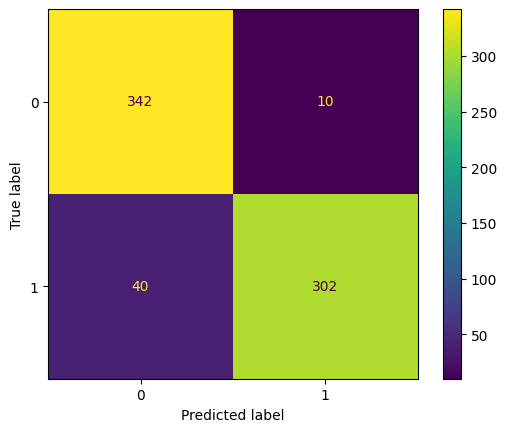

              precision    recall  f1-score   support

           0     0.8953    0.9716    0.9319       352
           1     0.9679    0.8830    0.9235       342

    accuracy                         0.9280       694
   macro avg     0.9316    0.9273    0.9277       694
weighted avg     0.9311    0.9280    0.9278       694

AUC-ROC Score: 0.9273


In [7]:
#Testing Predictions
y_pred = catbClassifier.predict(X_test)

#Create confusion matrix
catb_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=catb_cm)
disp.plot()
plt.show()

#Create classification report
catb_cr = classification_report(y_test, y_pred, digits=4)
print(catb_cr)

#AUC-ROC Score
print("AUC-ROC Score:", round(roc_auc_score(y_test,y_pred),4))

## 3.2. K-Folds Test

Just predict, no fit.

Checks if the model incurs overfitting.

In [8]:
def kfolds(X,y,model):
    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    sublist = [["accuracy", "f1_score","precision","recall","roc-auc","time"]]
    axis = 0
    for i, (train_index, test_index) in enumerate(kf.split(X,y)):
        print("Fold: " + str(i), end="") 
        start = time.time()
        training_set = np.take(X, train_index, axis)
        training_set_labels = np.take(y, train_index, axis)
        test_set = np.take(X, test_index, axis)
        test_set_labels = np.take(y, test_index, axis)
        model.fit(training_set,training_set_labels)
        m_pred = model.predict(test_set)
        sublist.append([
                        round(accuracy_score(test_set_labels, m_pred),4),
                        round(f1_score(test_set_labels, m_pred, average='weighted'),4),
                        round(precision_score(test_set_labels, m_pred,zero_division=0),4),
                        round(recall_score(test_set_labels, m_pred),4),
                        round(roc_auc_score(test_set_labels, m_pred),4),
                        round(time.time()-start,4)
                        ])
        print(" -", time.time()-start,"seconds")
    print("")
    return sublist

kfolds(X, y, catbClassifier)

Fold: 0 - 232.7765655517578 seconds
Fold: 1 - 224.20826768875122 seconds
Fold: 2 - 261.72229743003845 seconds
Fold: 3 - 293.239378452301 seconds
Fold: 4 - 238.18646049499512 seconds



[['accuracy', 'f1_score', 'precision', 'recall', 'roc-auc', 'time'],
 [0.9201, 0.9198, 0.9804, 0.8584, 0.9205, 232.7766],
 [0.9309, 0.9309, 0.9427, 0.9185, 0.931, 224.2083],
 [0.9309, 0.9309, 0.9548, 0.9056, 0.9311, 261.7223],
 [0.9372, 0.9372, 0.9677, 0.9052, 0.9374, 293.2394],
 [0.9156, 0.9155, 0.9447, 0.8836, 0.9157, 238.1865]]

## 3.3. Model Robustness Test

The model will then be evaluated using the `malbd_reserve` samples.

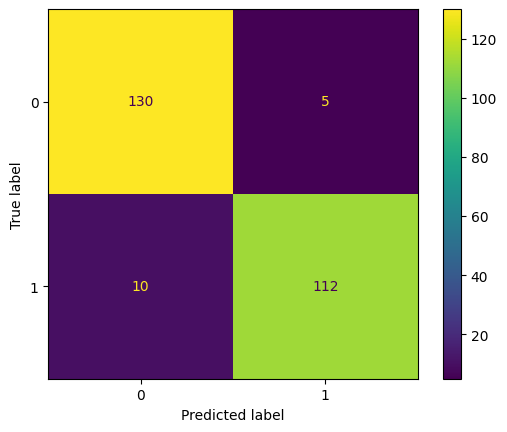

              precision    recall  f1-score   support

           0     0.9286    0.9630    0.9455       135
           1     0.9573    0.9180    0.9372       122

    accuracy                         0.9416       257
   macro avg     0.9429    0.9405    0.9413       257
weighted avg     0.9422    0.9416    0.9416       257

AUC-ROC Score: 0.9405


In [11]:
X,y = malbd_reserve.iloc[:,1:], malbd_reserve['labels']

#Testing Predictions
y_pred = catbClassifier.predict(X)

#Create confusion matrix
lgbm_cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=lgbm_cm)
disp.plot()
plt.show()

#Create classification report
lgbm_cr = classification_report(y, y_pred, digits=4)
print(lgbm_cr)

#AUC-ROC Score
print("AUC-ROC Score:", round(roc_auc_score(y, y_pred),4))